<h2>Project 5: Na&iuml;ve Bayes and the SVM</h2>

<blockquote>
    <center>
    <img src="nb.png" width="200px" />
    </center>
      <p><cite><center>"All models are wrong, but some are useful."<br>
       -- George E.P. Box
      </center></cite></p>
</blockquote>

<h3>Introduction</h3>
<!--Aðalbrandr-->

<p>A&eth;albrandr is visiting America from Norway and has been having the hardest time distinguishing boys and girls because of the weird American names like Jack and Jane.  This has been causing lots of problems for A&eth;albrandr when he goes on dates. When he heard that Cornell has a Machine Learning class, he asked that we help him identify the gender of a person based on their name to the best of our ability.  In this project, you will implement Na&iuml;ve Bayes to predict if a name is male or female. </p>

<h3> Of boys and girls </h3>

<p> Take a look at the files <code>girls.train</code> and <code>boys.train</code>. For example with the unix command <pre>cat girls.train</pre> 
<pre>
...
Addisyn
Danika
Emilee
Aurora
Julianna
Sophia
Kaylyn
Litzy
Hadassah
</pre>
Believe it or not, these are all more or less common girl names. The problem with the current file is that the names are in plain text, which makes it hard for a machine learning algorithm to do anything useful with them. We therefore need to transform them into some vector format, where each name becomes a vector that represents a point in some high dimensional input space. </p>

<p>That is exactly what the following Python function <code>name2features</code> does: </p>

In [1]:
#<GRADED>
import numpy as np
import sys
from cvxpy import *
from matplotlib import pyplot as plt
#</GRADED>

# add p03 folder
sys.path.insert(0, './p03/')

%matplotlib inline

In [2]:
def feature_extraction_letters(baby, B):
    v = np.zeros(B)
    for letter in baby:
        v[ord(letter) - 97] += 1
    return v

In [3]:
def name2features(filename, B=26, LoadFile=True):
    """
    Output:
    X : n feature vectors of dimension B, (nxB)
    """
    # read in baby names
    if LoadFile:
        with open(filename, 'r') as f:
            babynames = [x.rstrip() for x in f.readlines() if len(x) > 0]
    else:
        babynames = filename.split('\n')
    n = len(babynames)
    X = np.zeros((n, B))
    for i in range(n):
        X[i,:] = feature_extraction_letters(babynames[i].lower(), B)
    return X

It reads every name in the given file and converts it into a 26-dimensional feature vector by mapping each letter to a feature. </p> 

<p>We have provided you with a python function <code>genFeatures</code>, which calls this script, transforms the names into features and loads them into memory. 

In [4]:
def genFeatures(dimension, name2features, file_girls, file_boys):
    """
    function [x,y]=genFeatures
    
    This function calls the python script "name2features.py" 
    to convert names into feature vectors and loads in the training data. 
    
    name2features: function that extracts features from names
    dimension: dimensionality of the features
    
    Output: 
    x: n feature vectors of dimensionality d [d,n]
    y: n labels (-1 = girl, +1 = boy)
    """
    
    # Load in the data
    Xgirls = name2features(file_girls, B=dimension)
    Xboys = name2features(file_boys, B=dimension)
    X = np.concatenate([Xgirls, Xboys])
    
    # Generate Labels
    Y = np.concatenate([-np.ones(len(Xgirls)), np.ones(len(Xboys))])
    
    # shuffle data into random order
    ii = np.random.permutation([i for i in range(len(Y))])
    
    return X[ii, :], Y[ii]

You can call the following command to load in the features and the labels of all boys and girls names. 

In [5]:
X,Y = genFeatures(26, name2features, "girls.train", "boys.train")
xTe, yTe = genFeatures(26, name2features, "girls.test", "boys.test")

<h3> Multinomial Na&iuml;ve Bayes Classifier </h3>

<p> The Na&iuml;ve Bayes classifier is a linear classifier based on Bayes Rule. The following questions will ask you to finish these functions in a pre-defined order. <br>
<strong>As a general rule, you should avoid loops at all cost.</strong></p>
<p>(a) Estimate the class probability P(Y) in 
<b><code>naivebayesPY</code></b>
. This should return the probability that a sample in the training set is positive or negative, independent of its features.
</p>



In [6]:
#<GRADED>
def naivebayesPY(x,y):
    """
    function [pos,neg] = naivebayesPY(x,y);

    Computation of P(Y)
    Input:
        x : n input vectors of d dimensions (nxd)
        y : n labels (-1 or +1) (nx1)

    Output:
    pos: probability p(y=1)
    neg: probability p(y=-1)
    """
    
    # add one positive and negative example to avoid division by zero ("plus-one smoothing")
    y = np.append(y, [1, -1])

    ## fill in code here
    pos = np.mean(y==1)
    neg = np.mean(y==-1)
    
    return pos, neg


#</GRADED>

pos,neg = naivebayesPY(X,Y)

<p>(b) Estimate the conditional probabilities P(X|Y) <b>(Maximum Likelihood Estimate)</b> without smoothing in 
<b><code>naivebayesPXY_mle</code></b>
.  Use a <b>multinomial</b> distribution as model. This will return the probability vectors  for all features given a class label.
</p> 

In [7]:
#<GRADED>
def naivebayesPXY_mle(x,y):
    """
    function [posprob,negprob] = naivebayesPXY(x,y);
    
    Computation of P(X|Y) -- Maximum Likelihood Estimate
    Input:
        x : n input vectors of d dimensions (nxd)
        y : n labels (-1 or +1) (nx1)
    
    Output:
    posprob: probability vector of p(x|y=1) (1xd)
    negprob: probability vector of p(x|y=-1) (1xd)
    """
    
    ## fill in code here
    ind = (y == 1)
    posprob = np.sum( x[ind, :], axis=0, keepdims=True )
    posprob = posprob / np.sum( posprob )
    ind = (y == -1)
    negprob = np.sum( x[ind, :], axis=0, keepdims=True )
    negprob = negprob / np.sum( negprob )
    
    return posprob.flatten(), negprob.flatten()
    
#</GRADED>

posprob_mle,negprob_mle = naivebayesPXY_mle(X,Y)

<p>(c) Estimate the conditional probabilities P(X|Y) <b>(Smoothing with Laplace estimate)</b> in 
<b><code>naivebayesPXY_smoothing</code></b>
.  Use a <b>multinomial</b> distribution as model. This will return the probability vectors  for all features given a class label.
</p> 

In [8]:
#<GRADED>
def naivebayesPXY_smoothing(x,y):
    """
    function [posprob,negprob] = naivebayesPXY(x,y);
    
    Computation of P(X|Y) -- Smoothing with Laplace estimate
    Input:
        x : n input vectors of d dimensions (nxd)
        y : n labels (-1 or +1) (nx1)
    
    Output:
    posprob: probability vector of p(x|y=1) (1xd)
    negprob: probability vector of p(x|y=-1) (1xd)
    """
  
    ## fill in code here
    n, d = x.shape
    ind = (y == 1)
    posprob = np.sum( x[ind, :], axis=0, keepdims=True )
    posprob = (posprob + 1) / (np.sum( posprob ) + d)
    ind = (y == -1)
    negprob = np.sum( x[ind, :], axis=0, keepdims=True )
    negprob = (negprob + 1) / (np.sum( negprob ) + d)
    
    return posprob.flatten(), negprob.flatten()
    
#</GRADED>

posprob_smoothing,negprob_smoothing = naivebayesPXY_smoothing(X,Y)

<p>(d) Solve for the log ratio, $\log\left(\frac{P(Y=1 | X = xtest)}{P(Y=-1|X= xtest)}\right)$, using Bayes Rule.
 Implement this in 
<b><code>naivebayes</code></b>.
</p>



In [9]:
#<GRADED>
def naivebayes(x,y,xtest,naivebayesPXY):
    """
    function logratio = naivebayes(x,y);
    
    Computation of log P(Y|X=x1) using Bayes Rule
    Input:
    x : n input vectors of d dimensions (nxd)
    y : n labels (-1 or +1)
    xtest: input vector of d dimensions (1xd)
    naivebayesPXY: input function for getting conditional probabilities (naivebayesPXY_smoothing OR naivebayesPXY_mle)
    
    Output:
    logratio: log (P(Y = 1|X=xtest)/P(Y=-1|X=xtest))
    """
    
    ## fill in code here
    pos,neg = naivebayesPY(x,y) # = P(Y=+1 or -1)
    posprob,negprob = naivebayesPXY(x,y) # = P(X=x|Y=+1 or -1)
    # P(Y|X=xt) = P(X=x|Y)*P(Y)/P(X=x)
    # log(P(Y=1|X=xt)/P(Y=-1|X=xt)) = log((P(X=x|Y=1)*P(Y=1))/(P(X=x|Y=-1)*P(Y=-1)))
    logratio = np.sum( xtest * np.log(posprob) ) + np.log(pos) - \
               np.sum( xtest * np.log(negprob) ) - np.log(neg)
    return logratio

#</GRADED>
p_smoothing = naivebayes(X,Y,X[0,:], naivebayesPXY_smoothing)
p_mle = naivebayes(X,Y,X[0,:], naivebayesPXY_mle)

<p>(e) Naïve Bayes can also be written as a linear classifier. Implement this in 
<b><code>naivebayesCL</code></b>.

In [10]:
#<GRADED>
def naivebayesCL(x,y,naivebayesPXY):
    """
    function [w,b]=naivebayesCL(x,y);
    Implementation of a Naive Bayes classifier
    Input:
    x : n input vectors of d dimensions (nxd)
    y : n labels (-1 or +1)
    naivebayesPXY: input function for getting conditional probabilities (naivebayesPXY_smoothing OR naivebayesPXY_mle)

    Output:
    w : weight vector of d dimensions
    b : bias (scalar)
    """
    
    n, d = x.shape
    ## fill in code here
    pos,neg = naivebayesPY(x,y) # = P(Y=+1 or -1)
    posprob,negprob = naivebayesPXY(x,y) # = P(X=x|Y=+1 or -1)
    w = np.log(posprob) - np.log(negprob) 
    b = np.log(pos) - np.log(neg) 
    
    return w.flatten(), b

#</GRADED>

w_smoothing,b_smoothing = naivebayesCL(X,Y, naivebayesPXY_smoothing)
w_mle,b_mle = naivebayesCL(X,Y, naivebayesPXY_mle)

<p>(f) Implement 
<b><code>classifyLinear</code></b>
 that applies a linear weight vector and bias to a set of input vectors and outputs their predictions.  (You can use your answer from the previous project.)
 
 

In [11]:
#<GRADED>
def classifyLinear(x,w,b=0):
    """
    function preds=classifyLinear(x,w,b);
    
    Make predictions with a linear classifier
    Input:
    x : n input vectors of d dimensions (nxd)
    w : weight vector of d dimensions
    b : bias (optional)
    
    Output:
    preds: predictions
    """
    
    ## fill in code here
    preds = np.sign(x.dot(w)+b)
    return preds

#</GRADED>

print('Training error (Smoothing with Laplace estimate): %.2f%%' % (100 *(classifyLinear(X, w_smoothing, b_smoothing) != Y).mean()))
print('Training error (Maximum Likelihood Estimate): %.2f%%' % (100 *(classifyLinear(X, w_mle, b_mle) != Y).mean()))
print('Test error (Smoothing with Laplace estimate): %.2f%%' % (100 *(classifyLinear(xTe, w_smoothing, b_smoothing) != yTe).mean()))
print('Test error (Maximum Likelihood Estimate): %.2f%%' % (100 *(classifyLinear(xTe, w_mle, b_mle) != yTe).mean()))


Training error (Smoothing with Laplace estimate): 27.67%
Training error (Maximum Likelihood Estimate): 27.58%
Test error (Smoothing with Laplace estimate): 30.84%
Test error (Maximum Likelihood Estimate): 31.09%


You can now test your code with the following interactive name classification script:

In [ ]:
DIMS = 26
print('Loading data ...')
X,Y = genFeatures(DIMS, name2features, "girls.train", "boys.train")
xTe, yTe = genFeatures(26, name2features, "girls.test", "boys.test")
print('Training classifier (Smoothing with Laplace estimate) ...')
w,b=naivebayesCL(X,Y,naivebayesPXY_smoothing)
train_error = np.mean(classifyLinear(X,w,b) != Y)
test_error = np.mean(classifyLinear(xTe,w,b) != yTe)
print('Training error (Smoothing with Laplace estimate): %.2f%%' % (100 * train_error))
print('Test error (Smoothing with Laplace estimate): %.2f%%' % (100 * test_error))

yourname = ""
while yourname!="exit":
    yourname = input()
    if len(yourname) < 1:
        break
    xtest = name2features(yourname,B=DIMS,LoadFile=False)
    pred = classifyLinear(xtest,w,b)[0]
    if pred > 0:
        print("%s, I am sure you are a nice boy.\n" % yourname)
    else:
        print("%s, I am sure you are a nice girl.\n" % yourname)

Loading data ...
Training classifier (Smoothing with Laplace estimate) ...
Training error (Smoothing with Laplace estimate): 27.67%
Test error (Smoothing with Laplace estimate): 30.84%
Diana
Diana, I am sure you are a nice girl.

Sam
Sam, I am sure you are a nice girl.



<h3> Feature Extraction</h3>

<p> Similar to how we extracted features from names in <code>feature_extraction_letters</code>, we are going to try another way of doing so. This time, instead of mapping a letter to a feature, we will map a pair of letters to a feature. </p>
    
<p>
Every element in the feature vector will represent a pair of letters (e.g. 'aa', 'ab', 'ac'...) and the element representing the pair of letters that occur in the name will be 1, otherwise 0. Make sure your feature vector <b> ordering is alphabetical </b> i.e. ['aa', 'ab', 'ac'.....'ba', 'bb'......'ca','cb'......]. The length of the feature vector will be $26^2 = 676$ to represent all possible pairs of 26 alphabets. Assume everything is in lower case.
</p>

<p>
Here's an example, for the name 'sam', elements in the feature vector representing 'sa' and 'am' will be 1. All the other 674 features will be 0.
</p>

<p>
Please modify <code><b>feature_extraction_letters_pairs</b></code> below to implement this feature extraction.
</p>

In [ ]:
#<GRADED>
def feature_extraction_letters_pairs(name, B=676):
    """
    Feature extration from name for pairs
    name: name of the baby as a string
    
    Output:
    v : a feature vectors of dimension B=676, (B,)
    """
    v = np.zeros(B)
    # fill code in here
    for i in range(len(name)-1):
        ch1 = ord(name[i]) - 97
        ch2 = ord(name[i+1]) - 97
        v[ch1*26 + ch2] += 1
    # till here
    return v
    
def name2features_pairs(filename, B=676, LoadFile=True):
    """
    Output:
    X : n feature vectors of dimension B, (nxB)
    """
    if LoadFile:
        with open(filename, 'r') as f:
            babynames = [x.rstrip() for x in f.readlines() if len(x) > 0]
    else:
        babynames = filename.split('\n')
    n = len(babynames)
    X = np.zeros((n, B))
    for i in range(n):
        X[i,:] = feature_extraction_letters_pairs(babynames[i].lower(), B)
    return X

#</GRADED>

You can now test your code with the following interactive name classification script:

In [ ]:
''' result of the Naive Bayes classifier using pairs of letters as features '''
DIMS = 676
print('Loading data ...')
Xp,Yp = genFeatures(676, name2features_pairs, "girls.train", "boys.train")
xTe, yTe = genFeatures(676, name2features_pairs, "girls.test", "boys.test")
print('Training classifier (Smoothing with Laplace estimate) ...')
w,b=naivebayesCL(Xp,Yp,naivebayesPXY_smoothing)
train_error = np.mean(classifyLinear(Xp,w,b) != Yp)
print('Training error (Smoothing with Laplace estimate): %.2f%%' % (100 * train_error))
test_error = np.mean(classifyLinear(xTe,w,b) != yTe)
print('Test error (Smoothing with Laplace estimate): %.2f%%' % (100 * test_error))

yourname = ""
while yourname!="exit":
    print('Please enter your name>')
    yourname = input()
    if len(yourname) < 1:
        break
    xtest = name2features_pairs(yourname,B=DIMS,LoadFile=False)
    pred = classifyLinear(xtest,w,b)[0]
    if pred > 0:
        print("%s, I am sure you are a nice boy.\n" % yourname)
    else:
        print("%s, I am sure you are a nice girl.\n" % yourname)

<h2> SVM vs Naive Bayes</h2>

We will now explore the performance of soft-margin SVM in comparison to Naive Bayes on the same dataset:

In [ ]:
''' Implementation of soft-margin SVM '''

def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
        C     | the SVM regularization parameter
    
    Output:
        fun   | usage: predictions=fun(xTe); predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    
    w = Variable(d)
    b = Variable(1)
    e = Variable(N)
    objective = sum_squares(w) + C*sum(e)
    constraints = [e >= 0, 
                   multiply(y, xTr*w + b) >= 1-e]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    wout = w.value
    bout = b.value
    eout = e.value
    
    fun = lambda x: x.dot(wout) + bout
    return fun, wout, bout

Comparison of results for SVM vs Naive Bayes using single-letter features

In [ ]:
C=20

xTr,yTr = genFeatures(26, name2features, "girls.train", "boys.train")
xTe, yTe = genFeatures(26, name2features, "girls.test", "boys.test")
fun, _, _ = primalSVM(xTr, yTr, C)

svm_err_tr1=np.mean(np.array((np.sign(fun(xTr)))!=yTr).flatten())
print("Training error using SVM: %2.1f%%" % (svm_err_tr1*100))
nb_w,nb_b=naivebayesCL(xTr,yTr,naivebayesPXY_smoothing)
nb_train_error1 = np.mean(classifyLinear(xTr,nb_w,nb_b) != yTr)
print('Training error using Naive Bayes with smoothing: %.2f%%' % (100 * nb_train_error1))

svm_err_te1=np.mean(np.array((np.sign(fun(xTe)))!=yTe).flatten())
print("Test error using SVM: %2.1f%%" % (svm_err_te1*100))
nb_test_error1 = np.mean(classifyLinear(xTe,nb_w,nb_b) != yTe)
print('Test error using Naive Bayes with smoothing: %.2f%%' % (100 * nb_test_error1))

Comparison of results for SVM vs Naive Bayes using paired-letter features

In [26]:
xTr,yTr = genFeatures(676, name2features_pairs, "girls.train", "boys.train")
xTe, yTe = genFeatures(676, name2features_pairs, "girls.test", "boys.test")
fun, _, _ = primalSVM(xTr, yTr, C)

svm_err_tr2=np.mean(np.array((np.sign(fun(xTr)))!=yTr).flatten())
print("Training error using SVM: %2.1f%%" % (svm_err_tr2*100))
nb_w,nb_b=naivebayesCL(xTr,yTr,naivebayesPXY_smoothing)
nb_train_error2 = np.mean(classifyLinear(xTr,nb_w,nb_b) != yTr)
print('Training error using Naive Bayes with smoothing: %.2f%%' % (100 * nb_train_error2))

svm_err_te2=np.mean(np.array((np.sign(fun(xTe)))!=yTe).flatten())
print("Test error using SVM: %2.1f%%" % (svm_err_te2*100))
nb_test_error2 = np.mean(classifyLinear(xTe,nb_w,nb_b) != yTe)
print('Test error using Naive Bayes with smoothing: %.2f%%' % (100 * nb_test_error2))

Training error using SVM: 10.8%
Training error using Naive Bayes with smoothing: 24.92%
Test error using SVM: 27.5%
Test error using Naive Bayes with smoothing: 32.71%


Visual Comparison

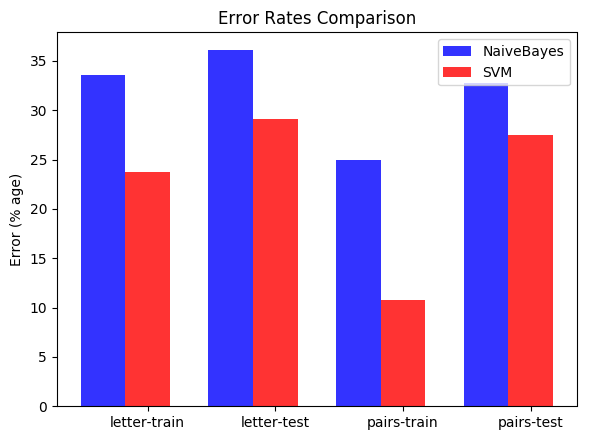

In [27]:
nb = [100 * nb_train_error1, 100 * nb_test_error1, 100 * nb_train_error2, 100 * nb_test_error2]
svm = [svm_err_tr1 * 100, 100 * svm_err_te1, svm_err_tr2 * 100, 100 * svm_err_te2]
n_groups = 4

fig, ax = plt.subplots(figsize=(6,4.5), dpi = 100)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, nb, bar_width,
alpha=opacity,
color='b',
label='NaiveBayes')

rects2 = plt.bar(index + bar_width, svm, bar_width,
alpha=opacity,
color='r',
label='SVM')

plt.xlabel('')
plt.ylabel('Error (% age)')
plt.title('Error Rates Comparison')
plt.xticks(index + bar_width, ('letter-train', 'letter-test', 'pairs-train', 'pairs-test'))
plt.legend()

plt.tight_layout()
plt.show()

<h4>Credits</h4>
  Parts of this webpage were copied from or heavily inspired by John DeNero's and Dan Klein's (awesome) <a href="http://ai.berkeley.edu/project_overview.html">Pacman class</a>. The name classification idea originates from <a href="http://nickm.com">Nick Montfort</a>.